In [91]:
# Part 1: Data Preprocessing and Visualization
## Hurricane Damage Classification Project
## By Keshav Bhargava and Sanjay Senthil

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [93]:
DATA_DIR = 'data/Project2'
DAMAGE_DIR = os.path.join(DATA_DIR, 'damage')
NO_DAMAGE_DIR = os.path.join(DATA_DIR, 'no_damage')
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
EPOCHS = 7

In [94]:
damage_files = os.listdir(DAMAGE_DIR)
no_damage_files = os.listdir(NO_DAMAGE_DIR)
print(f"\nDamage images: {len(damage_files)}")
print(f"No damage images: {len(no_damage_files)}")
print(f"Total images: {len(damage_files) + len(no_damage_files)}")


Damage images: 14170
No damage images: 7152
Total images: 21322


In [95]:
sample_damage = Image.open(os.path.join(DAMAGE_DIR, damage_files[0]))
sample_no_damage = Image.open(os.path.join(NO_DAMAGE_DIR, no_damage_files[0]))

print("\nSample Image Analysis:")
print(f"  Damage sample - Size: {sample_damage.size}, Mode: {sample_damage.mode}")
print(f"  No damage sample - Size: {sample_no_damage.size}, Mode: {sample_no_damage.mode}")


Sample Image Analysis:
  Damage sample - Size: (128, 128), Mode: RGB
  No damage sample - Size: (128, 128), Mode: RGB


In [96]:
# Check image dimension variability
print("\nChecking image dimension variability...")
damage_sizes = []
no_damage_sizes = []

# Sample 100 images from each class
for fname in damage_files[:100]:
    img = Image.open(os.path.join(DAMAGE_DIR, fname))
    damage_sizes.append(img.size)

for fname in no_damage_files[:100]:
    img = Image.open(os.path.join(NO_DAMAGE_DIR, fname))
    no_damage_sizes.append(img.size)

unique_sizes = set(damage_sizes + no_damage_sizes)
print(f"  Unique image sizes (from sample of 200): {len(unique_sizes)}")
if len(unique_sizes) <= 5:
    for size in unique_sizes:
        count = (damage_sizes + no_damage_sizes).count(size)
        print(f"    {size}: {count} images")


Checking image dimension variability...
  Unique image sizes (from sample of 200): 1
    (128, 128): 200 images


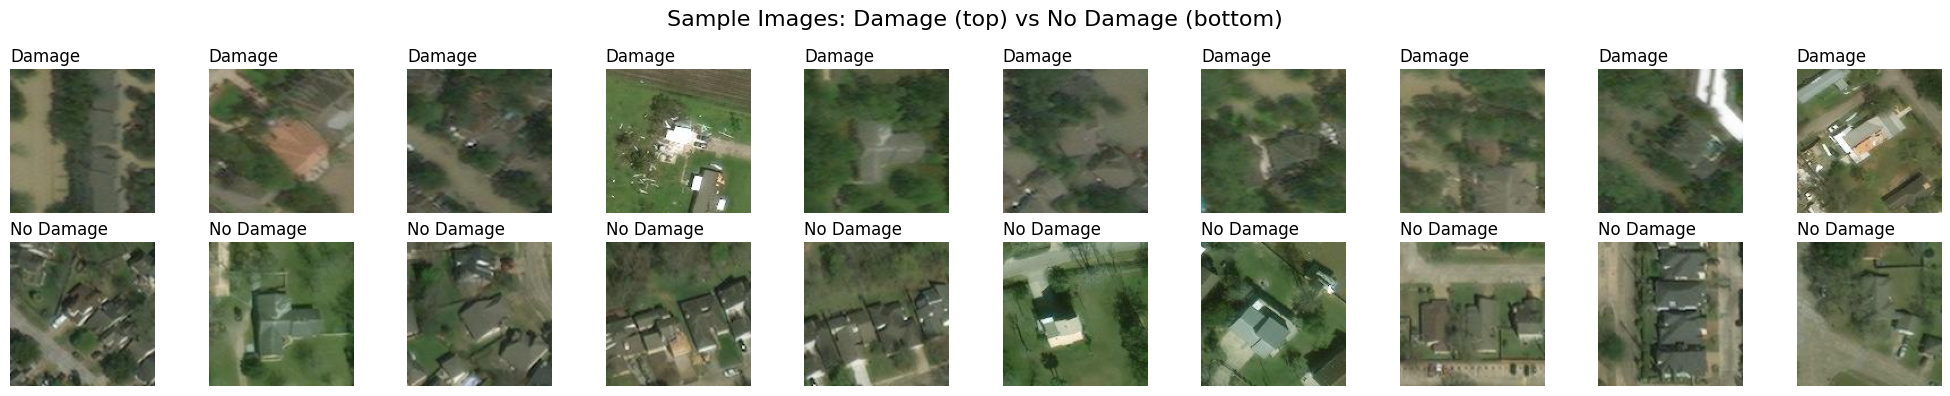

In [97]:
# Visualize sample images from both classes
num_samples = 10

fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
fig.suptitle('Sample Images: Damage (top) vs No Damage (bottom)', fontsize=16)

# Plot damage images
for i in range(num_samples):
    img = Image.open(os.path.join(DAMAGE_DIR, damage_files[i]))
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Damage', fontsize=12, loc='left')

# Plot no damage images  
for i in range(num_samples):
    img = Image.open(os.path.join(NO_DAMAGE_DIR, no_damage_files[i]))
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('No Damage', fontsize=12, loc='left')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

In [98]:
# The code below was generated by AI; see [1].
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.15
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [99]:
# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 3197 images belonging to 2 classes.
Found 21322 images belonging to 2 classes.


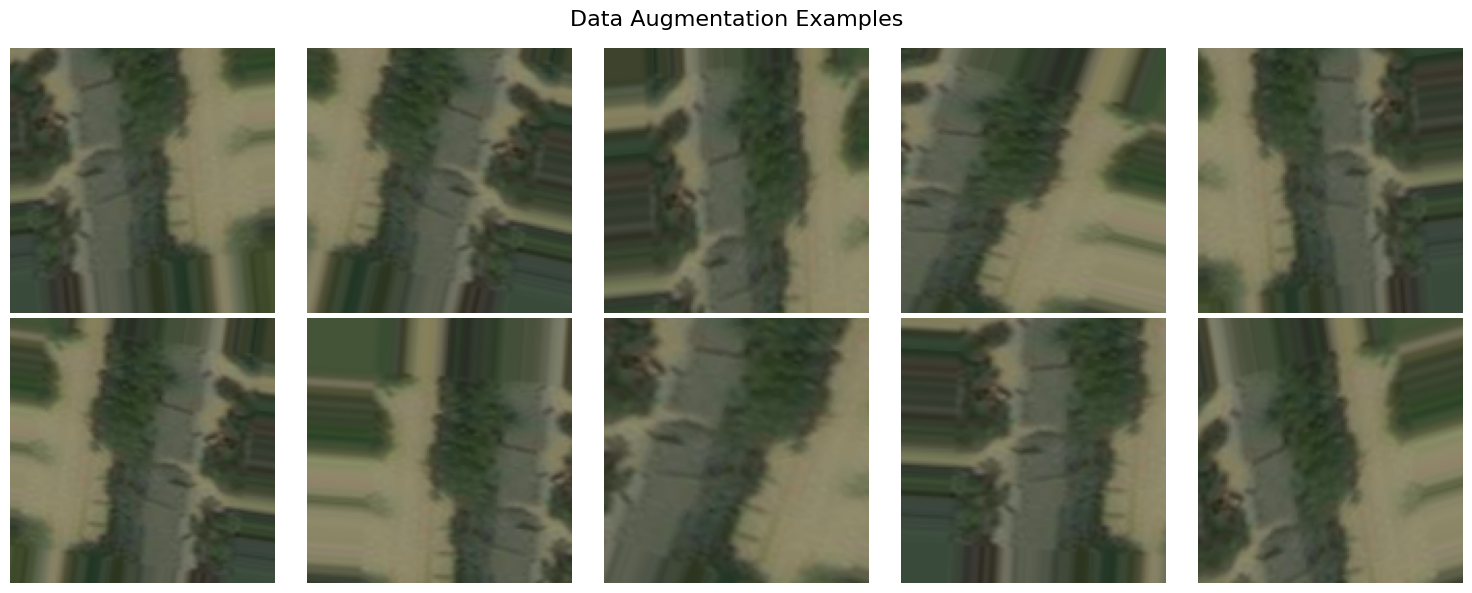

In [100]:
# The code below was generated by AI; see [2].
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

sample_img = Image.open(os.path.join(DAMAGE_DIR, damage_files[0]))
sample_img = sample_img.resize((IMG_HEIGHT, IMG_WIDTH))
img_array = np.array(sample_img)
img_array = img_array.reshape((1,) + img_array.shape)

# Generate augmented samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Augmentation Examples', fontsize=16)

i = 0
for batch in datagen.flow(img_array, batch_size=1):
    ax = axes[i // 5, i % 5]
    ax.imshow(batch[0].astype('uint8'))
    ax.axis('off')
    i += 1
    if i >= 10:
        break

plt.tight_layout()
plt.savefig('augmentation_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [101]:
# Part 2: Model Design, Training and Evaluation

In [102]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

In [103]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 18125 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.
Found 21322 images belonging to 2 classes.


In [104]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dropout(0.3))

# Hidden layer 1
model_dense.add(Dense(256, activation='relu'))
model_dense.add(Dropout(0.3))

# Hidden layer 2
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dropout(0.3))

# Hidden layer 3
model_dense.add(Dense(64, activation='relu'))

model_dense.add(Dense(1, activation='sigmoid'))
print("\nModel Architecture:")
model_dense.summary()


Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               25166336  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (Non

In [105]:
model_dense.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# The code below was generated by AI; see [3].
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'dense_ann_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history_dense = model_dense.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Epoch 1/7

Epoch 1: val_accuracy improved from -inf to 0.66469, saving model to dense_ann_best.keras
567/567 - 98s - loss: 0.9218 - accuracy: 0.6343 - val_loss: 0.6381 - val_accuracy: 0.6647 - 98s/epoch - 173ms/step
Epoch 2/7

Epoch 2: val_accuracy did not improve from 0.66469
567/567 - 98s - loss: 0.6397 - accuracy: 0.6637 - val_loss: 0.6379 - val_accuracy: 0.6647 - 98s/epoch - 173ms/step
Epoch 3/7

Epoch 3: val_accuracy did not improve from 0.66469
567/567 - 100s - loss: 0.6388 - accuracy: 0.6645 - val_loss: 0.6380 - val_accuracy: 0.6647 - 100s/epoch - 176ms/step
Epoch 4/7

Epoch 4: val_accuracy did not improve from 0.66469
567/567 - 99s - loss: 0.6388 - accuracy: 0.6642 - val_loss: 0.6379 - val_accuracy: 0.6647 - 99s/epoch - 175ms/step
Epoch 5/7

Epoch 5: val_accuracy did not improve from 0.66469
567/567 - 99s - loss: 0.6382 - accuracy: 0.6646 - val_loss: 0.6379 - val_accuracy: 0.6647 - 99s/epoch - 175ms/step
Epoch 6/7

Epoch 6: val_accuracy did not improve from 0.66469
567/567 - 10

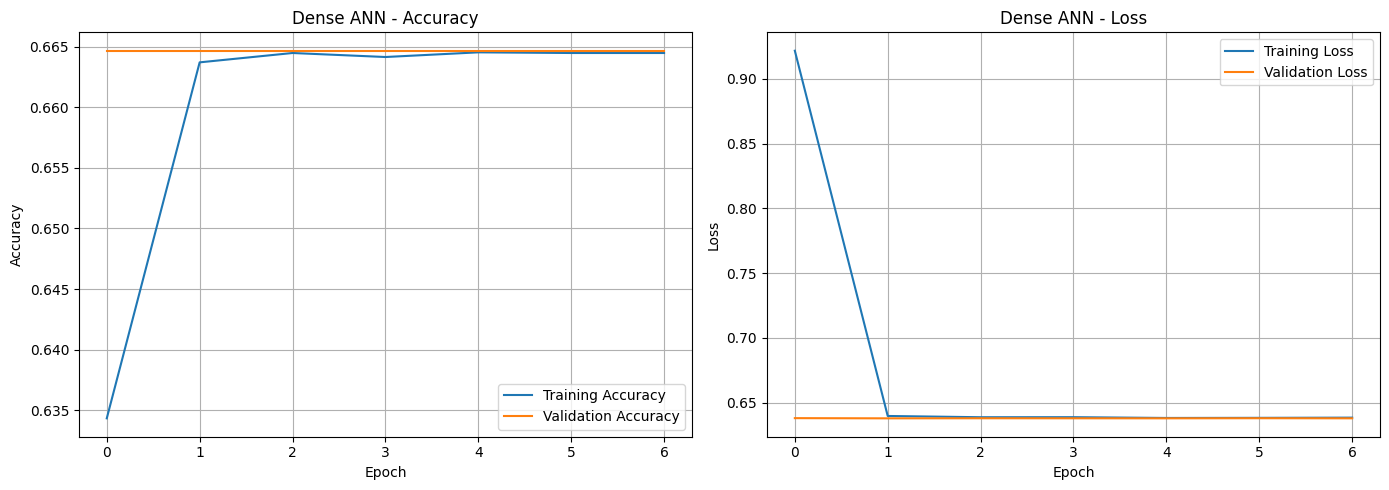

In [106]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history_dense.history['accuracy'], label='Training Accuracy')
ax1.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Dense ANN - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history_dense.history['loss'], label='Training Loss')
ax2.plot(history_dense.history['val_loss'], label='Validation Loss')
ax2.set_title('Dense ANN - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('dense_ann_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [107]:
test_loss_dense, test_accuracy_dense = model_dense.evaluate(test_generator, verbose=0)
print(f"Dense ANN Test Results:")
print(f"  Test Loss: {test_loss_dense:.4f}")
print(f"  Test Accuracy: {test_accuracy_dense:.4f}")

Dense ANN Test Results:
  Test Loss: 0.6380
  Test Accuracy: 0.6646


In [108]:
# --- LeNet-5 CNN ---

In [109]:
model_lenet5 = Sequential()
model_lenet5.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model_lenet5.add(AveragePooling2D(pool_size=(2, 2)))
model_lenet5.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(AveragePooling2D(pool_size=(2, 2)))
model_lenet5.add(Flatten())
model_lenet5.add(Dense(120, activation='relu'))
model_lenet5.add(Dense(84, activation='relu'))
model_lenet5.add(Dense(1, activation='sigmoid'))
model_lenet5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 13456)             0         
                                                                 
 dense_15 (Dense)            (None, 120)              

In [110]:
model_lenet5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Callbacks
early_stopping_lenet5 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_lenet5 = ModelCheckpoint(
    'lenet5_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history_lenet5 = model_lenet5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping_lenet5, checkpoint_lenet5],
    verbose=2
)

Epoch 1/7

Epoch 1: val_accuracy improved from -inf to 0.85486, saving model to lenet5_best.keras
567/567 - 66s - loss: 0.4048 - accuracy: 0.8254 - val_loss: 0.3973 - val_accuracy: 0.8549 - 66s/epoch - 116ms/step
Epoch 2/7

Epoch 2: val_accuracy did not improve from 0.85486
567/567 - 65s - loss: 0.2904 - accuracy: 0.8883 - val_loss: 1.0301 - val_accuracy: 0.5915 - 65s/epoch - 115ms/step
Epoch 3/7

Epoch 3: val_accuracy improved from 0.85486 to 0.85674, saving model to lenet5_best.keras
567/567 - 65s - loss: 0.2699 - accuracy: 0.8977 - val_loss: 0.3493 - val_accuracy: 0.8567 - 65s/epoch - 114ms/step
Epoch 4/7

Epoch 4: val_accuracy did not improve from 0.85674
567/567 - 64s - loss: 0.2305 - accuracy: 0.9105 - val_loss: 0.4633 - val_accuracy: 0.8092 - 64s/epoch - 113ms/step
Epoch 5/7

Epoch 5: val_accuracy improved from 0.85674 to 0.90616, saving model to lenet5_best.keras
567/567 - 65s - loss: 0.2158 - accuracy: 0.9136 - val_loss: 0.2337 - val_accuracy: 0.9062 - 65s/epoch - 114ms/step
E

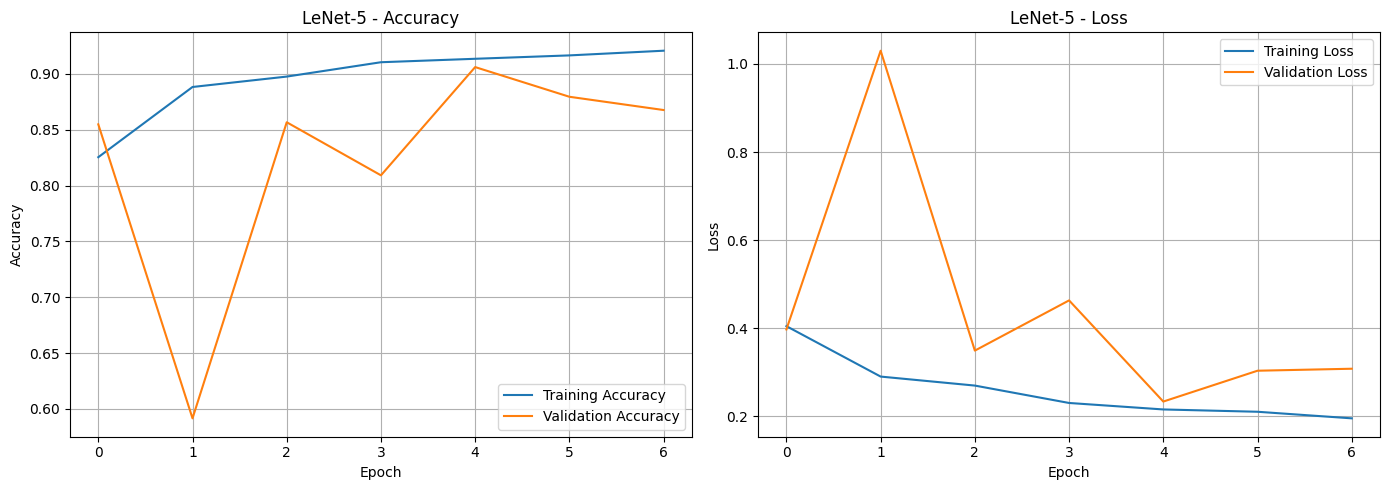

In [112]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history_lenet5.history['accuracy'], label='Training Accuracy')
ax1.plot(history_lenet5.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('LeNet-5 - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history_lenet5.history['loss'], label='Training Loss')
ax2.plot(history_lenet5.history['val_loss'], label='Validation Loss')
ax2.set_title('LeNet-5 - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('lenet5_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [121]:
test_loss_lenet5, test_accuracy_lenet5 = model_lenet5.evaluate(test_generator, verbose=0)
print(f"LeNet-5 Test Results:")
print(f"  Test Loss: {test_loss_lenet5:.4f}")
print(f"  Test Accuracy: {test_accuracy_lenet5:.4f}")

LeNet-5 Test Results:
  Test Loss: 0.1810
  Test Accuracy: 0.9240


In [122]:
# Model 3: Alternate-LeNet-5 CNN

In [123]:
model_alt_lenet5 = Sequential()
model_alt_lenet5.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model_alt_lenet5.add(MaxPooling2D(pool_size=(2, 2)))
model_alt_lenet5.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model_alt_lenet5.add(MaxPooling2D(pool_size=(2, 2)))
model_alt_lenet5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_alt_lenet5.add(MaxPooling2D(pool_size=(2, 2)))
model_alt_lenet5.add(Flatten())
model_alt_lenet5.add(Dense(256, activation='relu'))
model_alt_lenet5.add(Dropout(0.5))
model_alt_lenet5.add(Dense(128, activation='relu'))
model_alt_lenet5.add(Dropout(0.3))
model_alt_lenet5.add(Dense(1, activation='sigmoid'))
model_alt_lenet5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 128)      

In [124]:
model_alt_lenet5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stopping_alt = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_alt = ModelCheckpoint(
    'alternate_lenet5_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history_alt = model_alt_lenet5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping_alt, checkpoint_alt],
    verbose=2
)

Epoch 1/7

Epoch 1: val_accuracy improved from -inf to 0.64060, saving model to alternate_lenet5_best.keras
567/567 - 170s - loss: 0.5104 - accuracy: 0.7524 - val_loss: 0.6810 - val_accuracy: 0.6406 - 170s/epoch - 300ms/step
Epoch 2/7

Epoch 2: val_accuracy improved from 0.64060 to 0.85486, saving model to alternate_lenet5_best.keras
567/567 - 169s - loss: 0.2752 - accuracy: 0.8958 - val_loss: 0.3402 - val_accuracy: 0.8549 - 169s/epoch - 297ms/step
Epoch 3/7

Epoch 3: val_accuracy improved from 0.85486 to 0.90210, saving model to alternate_lenet5_best.keras
567/567 - 169s - loss: 0.2396 - accuracy: 0.9089 - val_loss: 0.2298 - val_accuracy: 0.9021 - 169s/epoch - 298ms/step
Epoch 4/7

Epoch 4: val_accuracy did not improve from 0.90210
567/567 - 166s - loss: 0.2093 - accuracy: 0.9182 - val_loss: 0.2823 - val_accuracy: 0.8840 - 166s/epoch - 293ms/step
Epoch 5/7

Epoch 5: val_accuracy did not improve from 0.90210
567/567 - 170s - loss: 0.1916 - accuracy: 0.9256 - val_loss: 0.2490 - val_accu

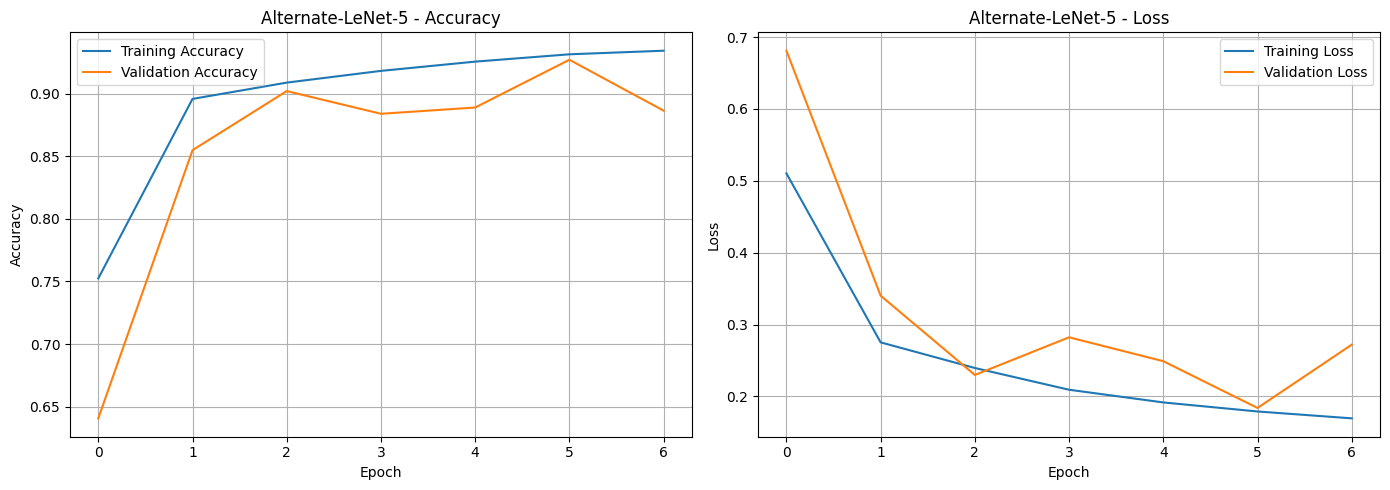

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history_alt.history['accuracy'], label='Training Accuracy')
ax1.plot(history_alt.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Alternate-LeNet-5 - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history_alt.history['loss'], label='Training Loss')
ax2.plot(history_alt.history['val_loss'], label='Validation Loss')
ax2.set_title('Alternate-LeNet-5 - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('alternate_lenet5_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [126]:
test_generator.reset()
test_loss_alt, test_accuracy_alt = model_alt_lenet5.evaluate(test_generator, verbose=0)
print(f"Alternate-LeNet-5 Test Results:")
print(f"  Test Loss: {test_loss_alt:.4f}")
print(f"  Test Accuracy: {test_accuracy_alt:.4f}")

Alternate-LeNet-5 Test Results:
  Test Loss: 0.1739
  Test Accuracy: 0.9304


In [127]:
results = {
    'Dense ANN': {'accuracy': test_accuracy_dense, 'loss': test_loss_dense},
    'LeNet-5': {'accuracy': test_accuracy_lenet5, 'loss': test_loss_lenet5},
    'Alternate LeNet-5': {'accuracy': test_accuracy_alt, 'loss': test_loss_alt}
}

print("=" * 60)
print("FINAL MODEL COMPARISON")
print("=" * 60)
for model_name, metrics in results.items():
    print(f"{model_name:20s} - Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['loss']:.4f}")

# Determine best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

FINAL MODEL COMPARISON
Dense ANN            - Accuracy: 0.6646, Loss: 0.6380
LeNet-5              - Accuracy: 0.9240, Loss: 0.1810
Alternate LeNet-5    - Accuracy: 0.9304, Loss: 0.1739

Best Model: Alternate LeNet-5 with accuracy 0.9304


In [128]:
with open('best_model_info.txt', 'w') as f:
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}\n")
    f.write(f"Test Loss: {results[best_model_name]['loss']:.4f}\n")

print(f"\nBest model info saved to 'best_model_info.txt'")
print(f"Best model saved as: {best_model_name.lower().replace(' ', '_').replace('-', '_')}_best.keras")


Best model info saved to 'best_model_info.txt'
Best model saved as: alternate_lenet_5_best.keras
